<a href="https://colab.research.google.com/github/iamchenchu/Deep-Learnig-with-TensorFlow/blob/main/06_transfer_learning_in_tensorflow_part2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine Tuning

In previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning : Fine tuning


In [47]:
#Check if we are using the GPU

!nvidia-smi

Thu Dec 21 20:35:04 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              33W /  70W |   4221MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Creating helper functions
In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

Instead of creating helper functions every time, create them in one notebook and keep them available maybe in your github and download that helper functions to the current notebook and inport the respective functions as per your requirement.





In [48]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-12-21 20:35:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-21 20:35:04 (68.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



**Note :** If you're running this notebook in google colab. when it times out Colab will delete `helper_functions.py`, so you will have to re download it, if you want to use the helper functions.


#Let's get some data

this time we're going to see how we can use the pretrained models ithin `tf.keras.applications` and apply them to our own problem (Recognizing images of food)

Link : https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [49]:
# Get 10% of the training data of classes of Food101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#Unzip the data

unzip_data("10_food_classes_10_percent.zip")




--2023-12-21 20:35:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.207, 108.177.13.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   143MB/s    in 1.1s    

2023-12-21 20:35:05 (143 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [50]:
#Check out how many images are there in the our dataset

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [51]:
# Create a training and test direcotry paths

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [52]:
# so far we were using ImageDataGenerator now let's use image_dataset_from_directory

import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [53]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [54]:
#Check out the class names of our dataset

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [55]:
# See an example of a batch of the data

for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.44830990e+01 1.21304207e+01 1.18845665e+00]
   [2.64968109e+01 1.44792738e+01 5.50446463e+00]
   [2.30124359e+01 1.09952173e+01 3.97799778e+00]
   ...
   [1.89412888e+02 1.14412895e+02 4.92617607e+01]
   [1.66021240e+02 9.23739090e+01 2.63158760e+01]
   [1.79840729e+02 1.06193413e+02 4.01353798e+01]]

  [[2.17101402e+01 1.16521044e+01 2.82621193e+00]
   [2.49556770e+01 1.58128204e+01 9.00032043e+00]
   [2.59225121e+01 1.68644753e+01 1.20385847e+01]
   ...
   [1.84253021e+02 1.09311058e+02 4.18770905e+01]
   [1.84757111e+02 1.09815155e+02 4.15249748e+01]
   [1.90548172e+02 1.15606209e+02 4.73160248e+01]]

  [[2.47509556e+01 1.29330368e+01 8.73246193e+00]
   [2.70599499e+01 1.64993629e+01 1.22796564e+01]
   [2.90698338e+01 1.83064423e+01 1.63064423e+01]
   ...
   [2.07886276e+02 1.32686630e+02 5.89601898e+01]
   [2.12833481e+02 1.37306702e+02 6.20165215e+01]
   [2.07563431e+02 1.32036652e+02 5.67464676e+01]]

  ...

  [[3.88387632e+00 4.35714293e+00 2.12050962e+00]
   [2

# Modeling Experiments we're running



# Model 0 : Building a transfer learning model usig the keras Functional API

The sequential API is straight-farward, it runs our layers in sequential order

But the functional API gives us more flexibility with our models :

In [56]:
#1. Create base model with tf.keras.applications

base_model = tf.keras.applications.EfficientNetB0(include_top = False)

#2. Freeze the base model (so the underlying pre trained patterns aren't updated during the training)
base_model.trainable = False

#3. Create inputs into our model
inputs = tf.keras.Input(shape = (224,224, 3), name = "input_layer")

#4.  If using ResNet50V2 you will need to normalize inputs  (you don't have to do it for efficientNet(s))
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs to base model : {x.shape}")

#6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after global average pooling : {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

#8. Combine the inputs with the outputs into model
model_0 = tf.keras.Model(inputs, outputs)

#9. compile the model
model_0.compile(loss ="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

#10.Fit the model
history_10_percent=model_0.fit(train_data_10_percent,
            epochs =5,
            steps_per_epoch = len(train_data_10_percent),
            validation_data = test_data,
            validation_steps = int(0.25 * len(test_data)),
            callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                     experiment_name = "10_percent_feature_extraction")])




Shape after passing inputs to base model : (None, 7, 7, 1280)
Shape after global average pooling : (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20231221-203520
Epoch 1/5
24/24 [==============================] - 19s 255ms/step - loss: 1.8754 - accuracy: 0.4067 - val_loss: 1.3135 - val_accuracy: 0.7056
Epoch 2/5
24/24 [==============================] - 6s 219ms/step - loss: 1.0965 - accuracy: 0.7813 - val_loss: 0.9006 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - 5s 183ms/step - loss: 0.7935 - accuracy: 0.8427 - val_loss: 0.7253 - val_accuracy: 0.8092
Epoch 4/5
24/24 [==============================] - 9s 338ms/step - loss: 0.6403 - accuracy: 0.8667 - val_loss: 0.6254 - val_accuracy: 0.8405
Epoch 5/5
24/24 [==============================] - 4s 148ms/step - loss: 0.5448 - accuracy: 0.8893 - val_loss: 0.5763 - val_accuracy: 0.8470


In [57]:
#Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.5668 - accuracy: 0.8556


[0.566794753074646, 0.8555999994277954]

In [58]:
#Check the layers in our base model

for number, layer in enumerate(base_model.layers):
  print(number, layer.name)

0 input_4
1 rescaling_7
2 normalization_3
3 rescaling_8
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [59]:
#How about the getting the summary of our model

base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, None, None, 3)        0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, None, None, 3)        7         ['rescaling_7[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_8 (Rescaling)     (None, None, None, 3)        0         ['normalization_3

In [60]:
#how about a summary of our model
model_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
________________

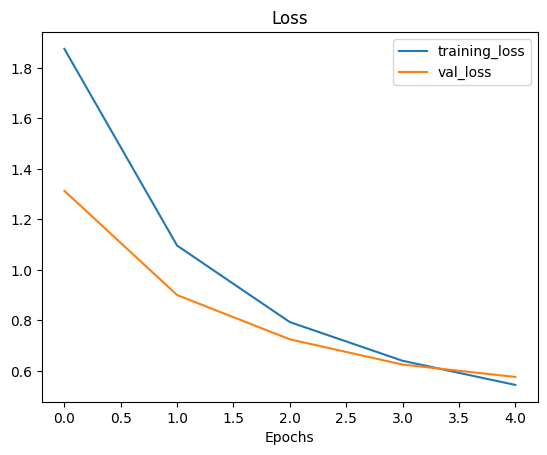

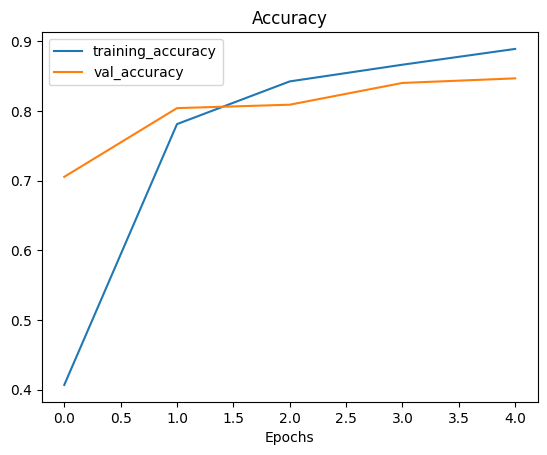

In [61]:
#Check out our model's training curves
plot_loss_curves(history_10_percent)

# Getting the feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer.....

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)

But then when it passes through GlobalAVeragePooling2D, it turns into (None,  1280).

Let's use similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.



In [62]:
#define the input shape
input_shape = (1, 4, 4, 3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

#pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor}\n")

#Check the shape of the different tensors
print(f"Shape of input tensor : {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor : {global_average_pooled_tensor.shape}")



Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor : (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor : (1, 3)


In [63]:
#Let's replicate the  GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Practice :** Try to do the same with the above two cells but this time use `GloabalMaxPool2D`... and see what happens.

`Note:` One of the resons feature extraction transfer learning is named how it is because what often happens is pretrained models outputs a feature vector(a long tensor of numbers which represents a learned representation of the model on a particular sample, in our case, this is the outpt of the `tf.keras.layers.GobalAveragePooling2D()` layer) which can then be used to extract patterns out of for our own specific probelem.




# Running a series of transfer learning experiments

 we'have see the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data with data...how about we set up a bunch of experiments to find out.

1. `model_1` - Use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine tuning transfer learning on 100% of the training data with data augmentation

**Note :** Throughout all experiments the same test dataset will be used to evaluate our model.. this ensures consistancy across evaluation metrics.



# Getting and pre processing data for model_1

In [64]:
#Download and unzip the data - preprocessed from food101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-12-21 20:36:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.207, 142.251.107.207, 74.125.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   131MB/s    in 1.0s    

2023-12-21 20:36:13 (131 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [65]:
# Create training and test dirs

train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [66]:
#How many images we are working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

In [67]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE) # default is 32


test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Adding the data augmentation right into our model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benifits of doing this within the tensorflow data augmentation documentation :     

off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:   

* Preprocessing of images (augmenting them) happens o the GPU (much faster) rather than the CPU
* Image data augmentation only happens during training, so we can still export our whole model using it elsewhere.



In [68]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation stage with horizontal flipping, rotations, zooms etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) $ Keep for models like ResNet50v2 but EfficientNe's having rescaling built
], name = "data_augmentation")

# Visualize our data augmentation layer (And see what happens to our data)



10_food_classes_1_percent/train/hamburger


(-0.5, 461.5, 270.5, -0.5)

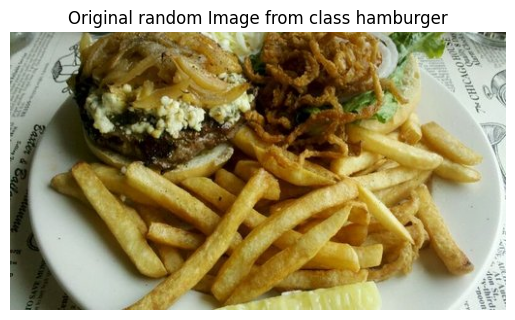

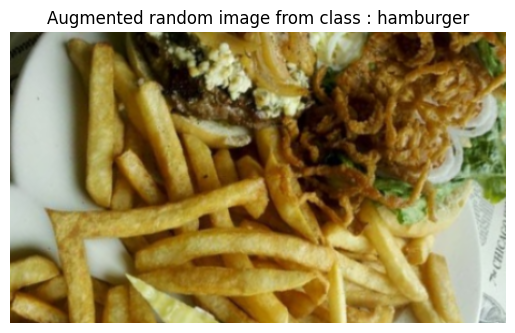

In [69]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
print(target_dir)
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image


#Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random Image from class {target_class}")
plt.axis(False)
#print(img)


#Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class : {target_class}")
plt.axis(False)
#print(augmented_img)

In [70]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

# Model 1 : Feature Extraction transfer learning on 1 percent data with data augmentation



In [71]:
#Setup input shape and base model, freezing the base model layers

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Crete the input layer
inputs = layers.Input(shape = input_shape, name = "input_layer")

#Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training = False)

#Pool output features of the base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

#Put a dense layer on as the output
outputs = layers.Dense(10, activation = "softmax", name="output_layer")(x)

#make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

#Compile the modle

model_1.compile (loss = "categorical_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ["accuracy"])

#Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs =5,
                        steps_per_epoch = len(train_data_1_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks =[create_tensorboard_callback(dir_name = "transfer_learning",
                                                                experiment_name = "1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20231221-203623
Epoch 1/5
3/3 [==============================] - 22s 3s/step - loss: 2.3899 - accuracy: 0.1143 - val_loss: 2.2691 - val_accuracy: 0.1349
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1200 - accuracy: 0.3143 - val_loss: 2.1501 - val_accuracy: 0.2039
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9368 - accuracy: 0.4286 - val_loss: 2.0302 - val_accuracy: 0.2878
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 1.7301 - accuracy: 0.5571 - val_loss: 1.9279 - val_accuracy: 0.3602
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6440 - accuracy: 0.6571 - val_loss: 1.8330 - val_accuracy: 0.4178


In [72]:
#Checkout our model summary

model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [73]:
#Evauate on full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 83ms/step - loss: 1.8432 - accuracy: 0.4076


[1.8431941270828247, 0.4075999855995178]

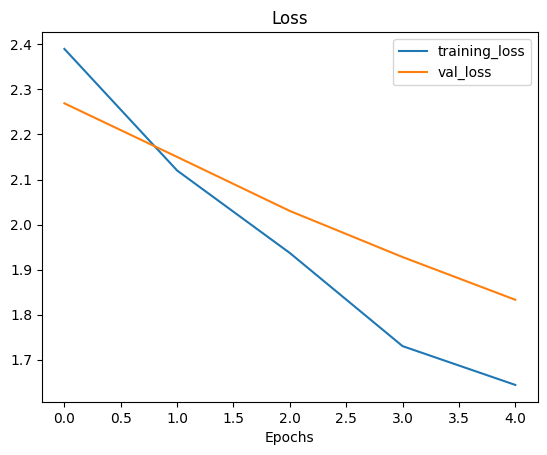

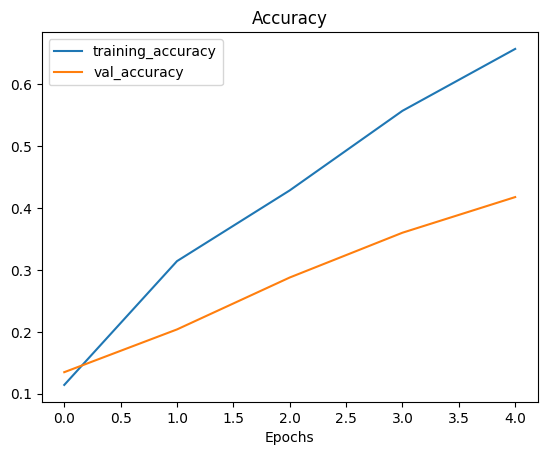

In [74]:
#How do the model with 1 percent of the data augmentation loss curves look ?

plot_loss_curves(history_1)

# Model 2 : Feature extraction transfer learning model with 10% of data and data and data augmentation



In [75]:
#get the 10% of the data

#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-12-21 20:37:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.207, 108.177.13.207, 172.217.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.3’

10_food_classes_10_ 100%[===================>] 160.74M   204MB/s    in 0.8s    

2023-12-21 20:37:22 (204 MB/s) - ‘10_food_classes_10_percent.zip.3’ saved [168546183/168546183]



In [76]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"




In [77]:
#How many images are in our directories ?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [78]:
#Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [79]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, None, None, 3)     0         
                                                                 
 random_rotation_2 (RandomR  (None, None, None, 3)     0         
 otation)                                                        
                                                                 
 random_zoom_2 (RandomZoom)  (None, None, None, 3)     0         
                                                                 
 random_height_2 (RandomHei  (None, None, None, 3)     0         
 ght)                                                            
                                                                 
 random_width_2 (RandomWidt  (None, None, None, 3)     0         
 h)                                                              
                                                 

In [80]:
#Create a model 2 with data augmentation built-in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Build the data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.Rescaling(1./255) # IF you're using a model such as ResNet50V2, you'll need to rescale your data, effficiantNet will have the rescaling built-in
], name = "data_augmentation")

#Setup the input shape for our model
input_shape =(224, 224, 3)

#Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs) # Augment out training images (Augmentation doesn't occur on test data)
x = base_model(x, training = False) # pass augmented images to the base model but keep it in inference mode, this also ensures batch-norm layers don't get updated
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

#Compile
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


# Creating a model-checkpoint callback

The ModelCheckpoint callback intermediatly saves our model (the full model or just the weights) during the training. this is useful so we can come and start where we left off.

In [81]:
#Check point path

checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

#Create a model checkpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch", #saves every epoch
                                                         verbose = 1)

# Fit the model_2 passing in the ModelCheckpoint callback


In [82]:
# Fit the model_2 passing in the ModelCheckpoint callback
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                   experiment_name = "10_percent_data_aug"),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20231221-203733
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.3456 - accuracy: 0.1160
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 29s 834ms/step - loss: 2.3456 - accuracy: 0.1160 - val_loss: 2.3228 - val_accuracy: 0.0855
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 2.3376 - accuracy: 0.0787
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 707ms/step - loss: 2.3376 - accuracy: 0.0787 - val_loss: 2.3161 - val_accuracy: 0.0970
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 2.3261 - accuracy: 0.0933
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 624ms/step - loss: 2.3261 - accuracy: 0.0933 - val_loss: 2.3109 - val_accuracy: 0.0872
E

In [83]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 71ms/step - loss: 0.5668 - accuracy: 0.8556


[0.5667946338653564, 0.8555999994277954]

In [84]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 81ms/step - loss: 2.3099 - accuracy: 0.0988


[2.3099143505096436, 0.09880000352859497]

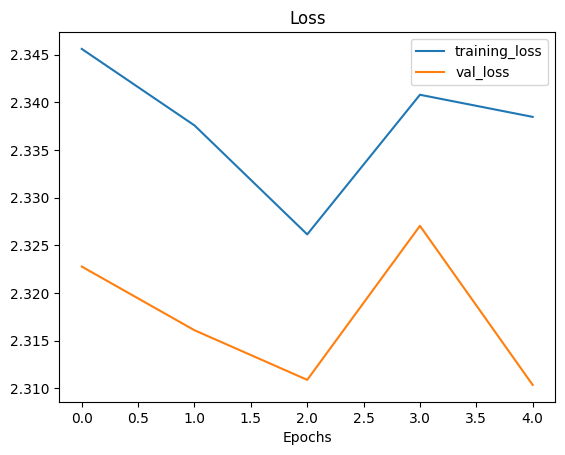

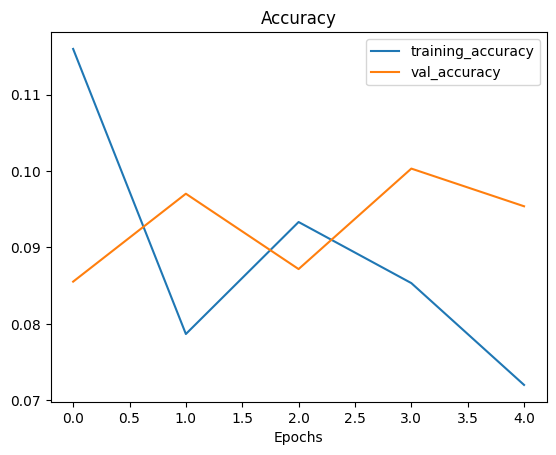

In [85]:
#Plot model loss curves

plot_loss_curves(history_10_percent_data_aug)

# Loading in Checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint


In [86]:
#Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [87]:
#evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 73ms/step - loss: 2.3099 - accuracy: 0.0988


In [88]:
#IF the results from our previously evaluated model_2 match the loaded weights, everything has worked !!
results_10_percent_data_aug == loaded_weights_model_results

True

In [89]:
results_10_percent_data_aug

[2.3099143505096436, 0.09880000352859497]

In [90]:
loaded_weights_model_results

[2.3099143505096436, 0.09880000352859497]

In [91]:
#Check to see if loaded model results are very close to our previous non-loaded model results

import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [92]:
#Check the difference between the two results
print(np.array(results_10_percent_data_aug)- np.array(loaded_weights_model_results))

[0. 0.]


# Model 3:  Fine-tuning an existing model on 10% data

> **Note :** Fine-tuning usually works best after training a feature extraction model for few epochs with large amounts of custom data.

In [93]:
#layers in loaded model

model_2.layers

In [95]:
#Are these layers trainable

for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7e0ef94b51b0> True
<keras.src.engine.sequential.Sequential object at 0x7e0ef68d4e20> True
<keras.src.engine.functional.Functional object at 0x7e0f7af16410> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7e0eed337ee0> True
<keras.src.layers.core.dense.Dense object at 0x7e0f7af39a50> True


In [96]:
# What layers are in our base_model (EfficientNetB0) and are they trainable ?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_6 False
1 rescaling_12 False
2 normalization_5 False
3 rescaling_13 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fa

In [97]:
# How many trainable variables are in our base models
print(len(model_2.layers[2].trainable_variables))


0


In [100]:
#To begin fine tuning, let's start by setting the last 10 layers of our base_model.trainable = True

base_model.trainable = True

#Freeze all the layers except for last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

#Recompile (We have to recompile our model every time we make a change)
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001), # when fine-tuning you typically want to lower the learning rate by 10x*
                metrics = ["accuracy"])




**Note :** When using fine tuning it's best practice to lower your learning rate by some amount. How much ? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values). A good resource for information on this is the ULMFiT. : https://arxiv.org/abs/1801.06146

In [102]:
#Check which layers are tunable (Trainable)

for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)




0 input_6 False
1 rescaling_12 False
2 normalization_5 False
3 rescaling_13 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fa

In [103]:
#Now we unfrozen some of the layers closer to the top, how many variables are there which are trainable

print(len(model_2.trainable_variables))

12


In [104]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [109]:
#Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

#Refit the model (Same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25 * len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1],
                                               callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                        experiment_name = "10_percent_fine_tune_last_10")]) #Start training from previous last epoch


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20231221-224634
Epoch 5/10
24/24 [==============================] - 33s 870ms/step - loss: 2.3678 - accuracy: 0.1013 - val_loss: 2.3310 - val_accuracy: 0.1184
Epoch 6/10
24/24 [==============================] - 13s 530ms/step - loss: 2.3430 - accuracy: 0.0947 - val_loss: 2.3195 - val_accuracy: 0.0806
Epoch 7/10
24/24 [==============================] - 14s 562ms/step - loss: 2.3332 - accuracy: 0.0680 - val_loss: 2.3224 - val_accuracy: 0.0822
Epoch 8/10
24/24 [==============================] - 15s 612ms/step - loss: 2.3208 - accuracy: 0.0907 - val_loss: 2.3063 - val_accuracy: 0.1069
Epoch 9/10
24/24 [==============================] - 11s 428ms/step - loss: 2.3101 - accuracy: 0.0947 - val_loss: 2.3075 - val_accuracy: 0.1020
Epoch 10/10
24/24 [==============================] - 15s 594ms/step - loss: 2.3087 - accuracy: 0.0627 - val_loss: 2.3079 - val_accuracy: 0.1020


In [110]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 12s 134ms/step - loss: 2.3064 - accuracy: 0.1000


In [111]:
results_10_percent_data_aug

[2.3099143505096436, 0.09880000352859497]

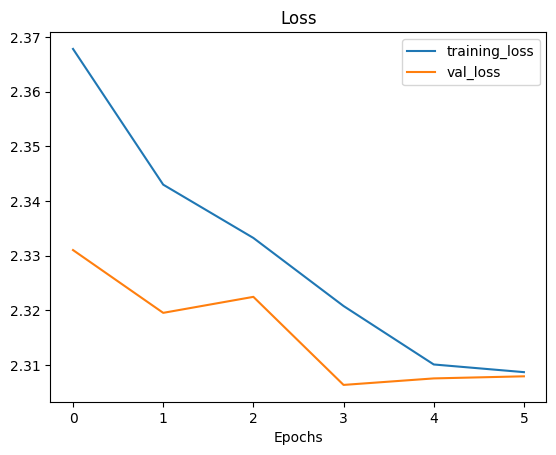

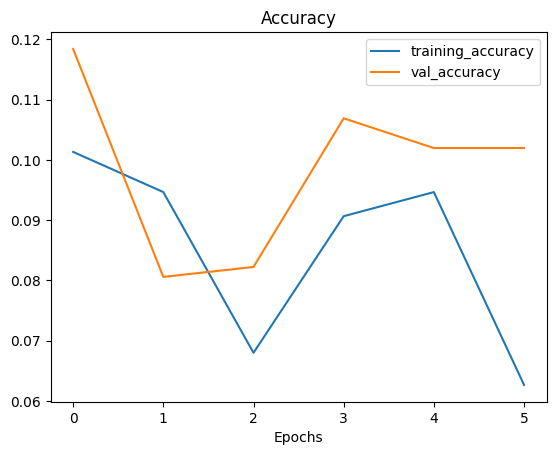

In [112]:
#check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)


The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running fit() with another (eg : before and after fine tuning)



In [117]:
#Let's create a function to compare training histories

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


5
11
[0.11599999666213989, 0.07866666465997696, 0.09333333373069763, 0.08533333241939545, 0.07199999690055847, 0.10133333504199982, 0.09466666728258133, 0.06800000369548798, 0.09066666662693024, 0.09466666728258133, 0.06266666948795319]


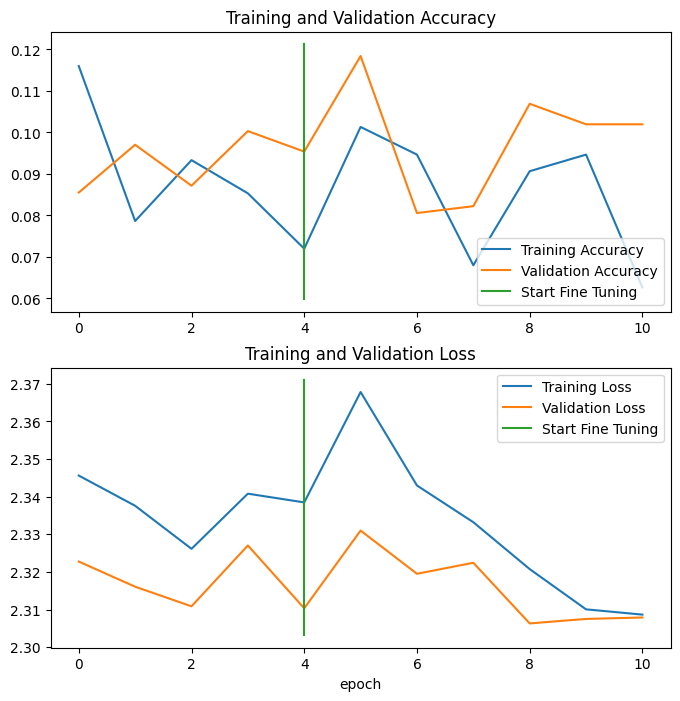

In [118]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)